# https://towardsdatascience.com/an-in-depth-efficientnet-tutorial-using-tensorflow-how-to-use-efficientnet-on-a-custom-dataset-1cab0997f65c

first import the neccessary stuff and check if the gpu is available

In [46]:
from keras.applications import * #Efficient Net included here
from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
import timm
import numpy as np
import os
import shutil
import pandas as pd
from sklearn import model_selection
from tqdm import tqdm
from keras import optimizers
import tensorflow as tf #Use this to check if the GPU is configured correctly
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3685610719315736730
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2915486926
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10112325651746135735
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:2d:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


setup a model

In [47]:
height, width = 64,64
input_shape=(height,width, 3)
conv_base = EfficientNetB6(weights="imagenet", include_top=False, input_shape=input_shape)

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
#avoid overfitting
model.add(layers.Dropout(rate=0.25, name="dropout_out"))
# Set NUMBER_OF_CLASSES to the number of your final predictions.
NUMBER_OF_CLASSES = 10
model.add(layers.Dense(NUMBER_OF_CLASSES, activation="softmax", name="fc_out"))
conv_base.trainable = True #Now I get more than 10%?

setup dirs for training and validation files

In [48]:
TRAIN_IMAGES_PATH = './imagenette2-160/images/train' #12000
VAL_IMAGES_PATH = './imagenette2-160/images/val' #3000
os.makedirs(TRAIN_IMAGES_PATH, exist_ok = True)
os.makedirs(VAL_IMAGES_PATH, exist_ok = True)

classes = [ "n01440764", "n02102040", "n02979186", "n03000684", "n03028079", "n03394916", "n03417042", "n03425413", "n03445777", "n03888257"]# Create directories for each class.
for class_id in [x for x in range(len(classes))]:
    os.makedirs(os.path.join(TRAIN_IMAGES_PATH, str(classes[class_id])), exist_ok = True)
    os.makedirs(os.path.join(VAL_IMAGES_PATH, str(classes[class_id])), exist_ok = True)

Input_dir = './imagenette2-160/'
def preproccess_data(df, images_path):
    for column, row in tqdm(df.iterrows(), total=len(df)):
        class_id = row['noisy_labels_0']

        shutil.copy(os.path.join(Input_dir, f"{row['path']}"), os.path.join(images_path, str(class_id)))

load the .csv, split it into test and validation data.

In [49]:
df = pd.read_csv('./imagenette2-160/noisy_imagenette.csv')
df.head()
#Split the dataset into 80% training and 20% validation
df_train, df_valid = model_selection.train_test_split(df, test_size=0.2, random_state=42, shuffle=True)#run the  function on each of them
preproccess_data(df_train, TRAIN_IMAGES_PATH)
preproccess_data(df_valid, VAL_IMAGES_PATH)

100%|██████████| 2679/2679 [00:02<00:00, 1194.71it/s]


Build generators and compile the model.

In [50]:
# I love the  ImageDataGenerator class, it allows us to specifiy whatever augmentations we want so easily...
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)# Note that the validation data should not be augmented!#and a very important step is to normalise the images through  rescaling
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

batch_size = 16

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    TRAIN_IMAGES_PATH,
    # All images will be resized to target height and width.
    target_size=(height, width),
    batch_size=batch_size,
    # Since we use categorical_crossentropy loss, we need categorical labels
    class_mode="categorical",
)
validation_generator = test_datagen.flow_from_directory(
    VAL_IMAGES_PATH,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode="categorical",
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.RMSprop(lr=4e-5),
    metrics=["acc"],
)

Found 11384 images belonging to 10 classes.
Found 2679 images belonging to 10 classes.


c:\Users\profc\.conda\envs\Datamining\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Train the model

In [77]:
#Train
epochs = 2 #work through the dataset
NUMBER_OF_TRAINING_IMAGES = 10715
NUMBER_OF_VALIDATION_IMAGES = 2679
history = model.fit(
    train_generator,
    batch_size = batch_size, #batch_size default is 32!
    steps_per_epoch=NUMBER_OF_TRAINING_IMAGES // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=NUMBER_OF_VALIDATION_IMAGES // batch_size,
    verbose=1, #progress bar
    use_multiprocessing=False, #use process-base threading
    workers=1, #max processes, if multiprocessing
)

Epoch 1/2
669/669 [==============================] - 408s 610ms/step - loss: 0.9158 - acc: 0.6960 - val_loss: 0.6635 - val_acc: 0.7841
Epoch 2/2
669/669 [==============================] - 408s 610ms/step - loss: 0.8426 - acc: 0.7261 - val_loss: 0.5851 - val_acc: 0.8076


Found 16 images belonging to 10 classes.


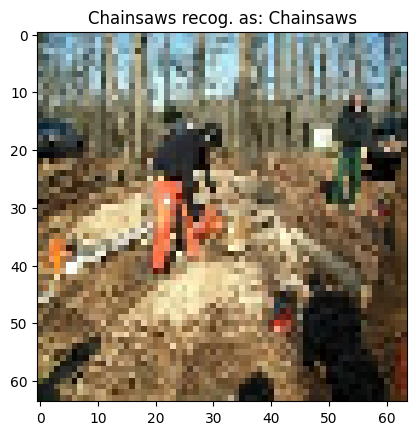

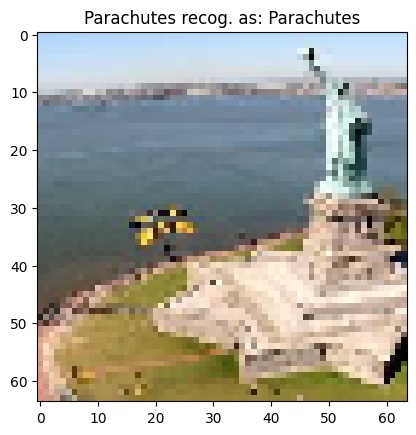

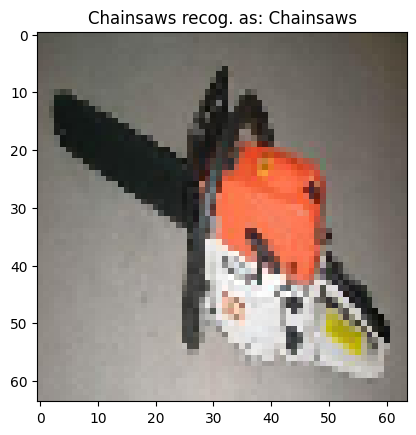

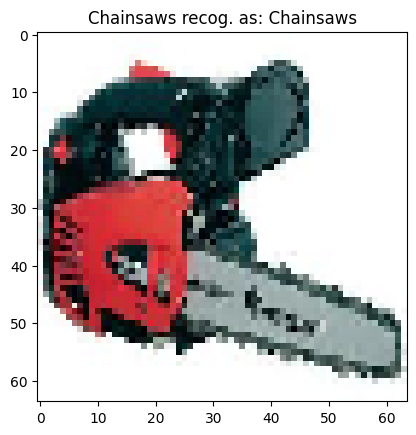

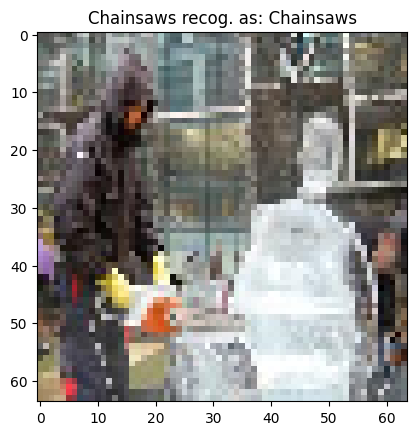

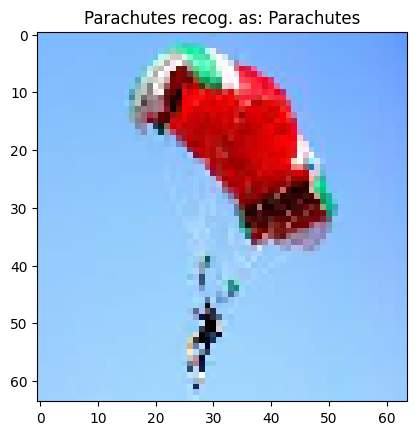

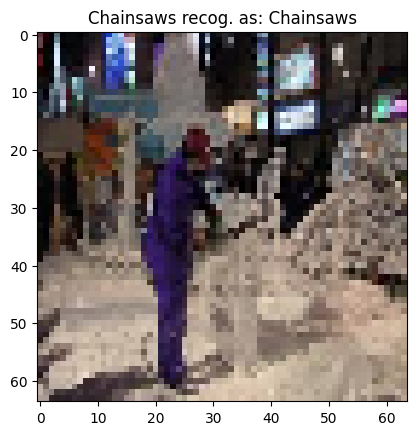

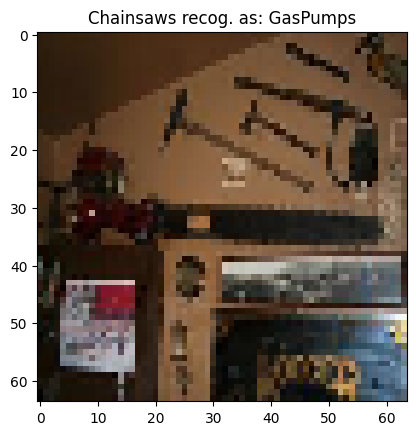

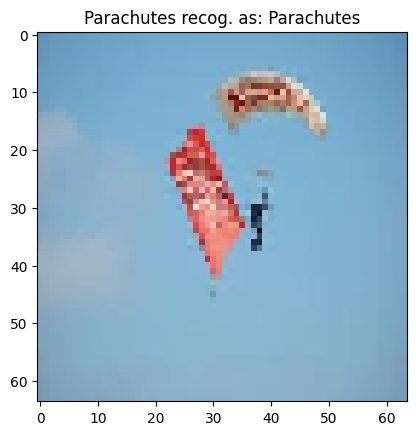

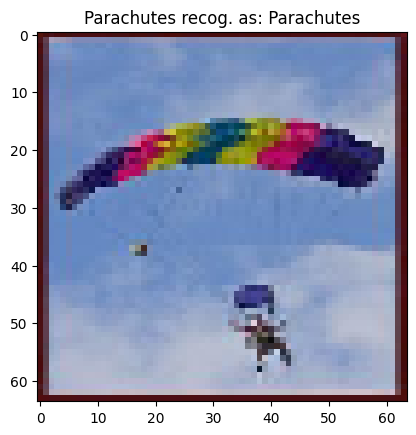

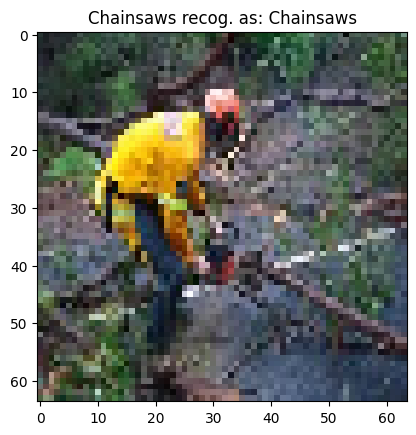

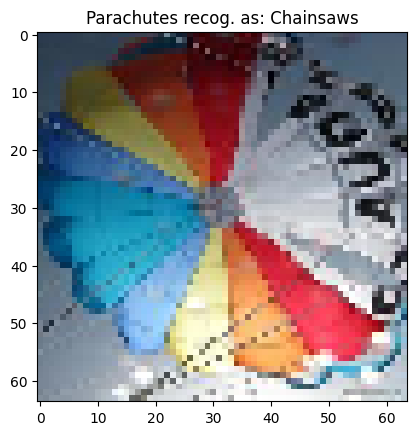

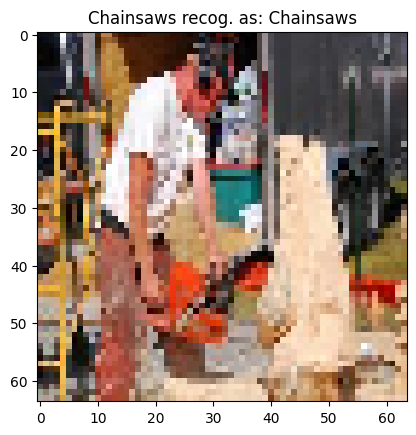

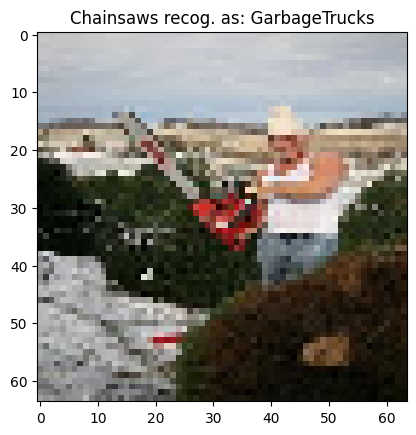

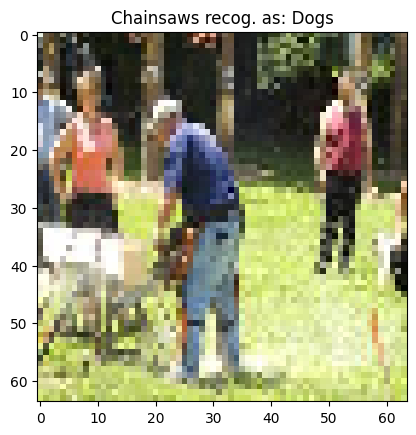

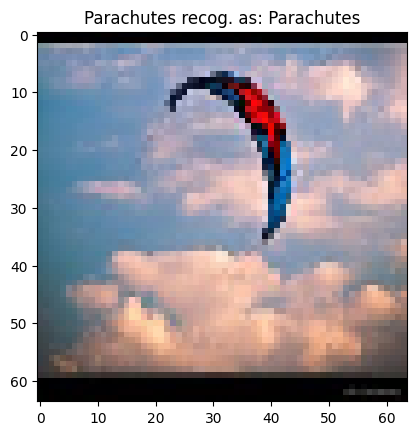

lossValue: 0.880577564239502 metricsValues(acc!?): 0.75
[3 9 3 3 3 9 3 3 9 9 3 9 3 3 3 9] [3 9 3 3 3 9 3 7 9 9 3 3 3 6 1 9]
confusionMatrix 
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 7 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 5]]
precisionScore 0.75
recallScore 0.75
f1Score 0.75
_________________done__________________


In [102]:
import matplotlib.pyplot as plt
batch_size = 16
#unnecessary dict...we dont get the keys, we get indexes
names = {"n01440764": "Fishes",
         "n02102040": "Dogs", 
         "n02979186": "PortableMusicPlayers", 
         "n03000684": "Chainsaws", 
         "n03028079": "Churchs", 
         "n03394916": "Horns", 
         "n03417042": "GarbageTrucks", 
         "n03425413": "GasPumps", 
         "n03445777": "GolfBalls", 
         "n03888257": "Parachutes"}

TEST_IMAGES_PATH = "./imagenette2-160/images/test"
test_generator = test_datagen.flow_from_directory(
    TEST_IMAGES_PATH,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode="categorical",
)

names = ["Fishes", "Dogs", "PortableMusicPlayers", "Chainsaws", "Churchs", "Horns", "GarbageTrucks", "GasPumps", "GolfBalls",  "Parachutes"]
def getPredName(preds):
    max = 0e-1 #p=0% is lowest p
    index = -1 #index out of bounds is first under normal indexes
    for i in range(len(names)):
        if preds[i] > max: 
            #print(preds[i],">", max, "switching from", index, "to", i)
            max = preds[i]
            index = i
    return names[index]

once = 0
for samplebatch in test_generator:
    if(once > 0): break
    once += 1
    #these are batches of samples, batchsize is defined before
    #print(type(sample)) #tuple
    x_test, y_test = samplebatch
    #print(y_test) #looks like a 100% prediction
    #[[0.],[0.],[0.],[1.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.]] 
    #print(np.shape(x_test),np.shape(y_test)) #(16, 440, 440, 3) (16, 1)
    #print(np.shape(x_test[0]),np.shape(y_test[0])) #(440, 440, 3) (1,)
    #print(np.shape(x_test[0]),np.shape(y_test[0][0])) #(440, 440, 3) ()

    #print n-examples with right labels
    n = 0
    #n = batch_size
    for i in range(n):
        plt.title(getPredName(y_test[i]))
        plt.imshow(x_test[i], cmap="brg")
        plt.show()

    #predict
    y_pred = model.predict(x_test, verbose=0) #use our model to predict a batch
    #print("y_pred shape", np.shape(y_pred)) # (16, 10)
    #print(y_pred)
    n = 0
    #n = 3
    n = batch_size
    for i in range(n):
        #print("Target:", getPredName(y_test[i]),"Saw",y_pred[i][3],"Chute", y_pred[i][9])
        #print("predicted", getPredName(y_pred[i]), y_pred[i])
        #print("predicted", getPredName(y_pred[i]), "for image", i+1)
        
        plt.title(getPredName(y_test[i])+" recog. as: "+getPredName(y_pred[i]))
        plt.imshow(x_test[i], cmap="brg")
        plt.show()

    lossValue, metricsValues = model.evaluate(x_test,y_test,
                                              verbose=0) #hide the output
    print("lossValue:", lossValue, "metricsValues(acc!?):", metricsValues)

    #evaluate
    # Import the modules from `sklearn.metrics` 
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score 

    # TODO: Bugfix the following calls
    #print(np.shape(y_test),np.shape(y_pred)) #(16, 10) (16, 10)
    #print(y_test,y_pred)
    #print(type(y_test),type(y_pred)) #<class 'numpy.ndarray'> <class 'numpy.ndarray'>
    y_pred_max = np.argmax(y_pred, axis=1)
    y_test_max = np.argmax(y_test, axis=1)
    #print(np.shape(y_test_max),np.shape(y_pred_max)) #(16, 10) (16, 10)
    print(y_test_max,y_pred_max) #[9 3 3 9 9 3 9 3 3 3 9 3 3 3 9 3] [9 3 7 6 9 3 2 3 3 7 9 5 1 4 9 3]
    #print(type(y_test_max),type(y_pred_max)) #<class 'numpy.ndarray'> <class 'numpy.ndarray'>
    
    # Confusion matrix 
    cm = confusion_matrix(y_test_max, y_pred_max, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    print("confusionMatrix \n", cm)

    ps = precision_score(y_test_max, y_pred_max, average = "micro")
    print("precisionScore", ps)

    rs = recall_score(y_test_max, y_pred_max, average = "micro")
    print("recallScore", rs)

    f1 = f1_score(y_test_max,y_pred_max, average = "micro")
    print("f1Score", f1)

    print("_________________done__________________")